### Preparazione dati di supporto

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import holidays

In [2]:
buffer = [n for n in range(21, 29)]
buffer.extend([n for n in range(31, 39)])

legenda_gualchierani = {
    'fuori_impianto': [0],
    'ing_zona_misc': [1],
    'catenaria_ing_misc': [45, 46],
    'navetta_serv_misc': [43],
    'pesatura': [41, 42],
    'miscelatore': [2, 8],
    'cat_usc_pieni': [3],
    'nav_serv_carr_pieni': [4],
    'nav_serv_carr_vuoti': [5],
    'buffer': buffer,
    'carroponte_1': [6],
    'carroponte_2': [7],
    'estrusore': [n for n in range(11, 19)],
    'handling_post_est': [6, 5, 4],
    'catenaria_vuoti': [47, 48],
    'catenaria_uscita_vuoti': [49],
    'pinza_vuoti': [50],
    'catenaria_parcheggi': [n for n in range(51, 58)],
    'nav_serv_parcheggi': [44],
    'manuale': [68, 70]
}

dict_states = {
    0: 'Not_def',
    1: 'V_per_park',
    2: 'P_da_misc',
    3: 'P_da_est',
    4: 'P_remove',
    5: 'P_recheck',
    6: 'P_per_park',
    7: 'V_da_pes',
    8: 'V_remove',
    9: 'V_lavaggio'
}

starter = ['V_da_pes/nav_serv_carr_pieni', 'V_da_pes/nav_serv_carr_vuoti',
'V_da_pes/catenaria_vuoti', 'V_da_pes/catenaria_parcheggi',
'V_da_pes/nav_serv_parcheggi', 'V_da_pes/catenaria_ing_misc',
'V_da_pes/ing_zona_misc']

finisher = ['P_da_est/estrusore', 'Not_def/fuori_impianto']

finisher2 = ['V_per_park/estrusore', 'V_da_pes/estrusore', 'Not_def/fuori_impianto']

In [3]:
#  questa funzione estrae dal df il primo record in ordine temporale per ogni ubicazione

def create_df_t_new(df, cono_in_esame):
    mask = df['id_cono'] == cono_in_esame
    df1 = df[mask]

    ubicazione = []
    stato = []
    timestamp = []
    stazione = []
    miscelatore = []
    for i in range(1, len(df1) - 1):
        if df1.iloc[i, 1] in legenda_gualchierani['pesatura']:
            if (df1.iloc[i, 1] != df1.iloc[i - 1, 1]) or (df1.iloc[i, 1] != df1.iloc[i + 1, 1]):
                ubicazione.append(df1.iloc[i, 1])
                stato.append(df1.iloc[i, 2])
                timestamp.append(df1.iloc[i, 5])
                stazione.append(df1.iloc[i, 3])
                miscelatore.append(df1.iloc[i, 4])
        elif df1.iloc[i, 1] in legenda_gualchierani['miscelatore']:
            if (df1.iloc[i, 1] != df1.iloc[i - 1, 1]) or (df1.iloc[i, 1] != df1.iloc[i + 1, 1]):
                ubicazione.append(df1.iloc[i, 1])
                stato.append(df1.iloc[i, 2])
                timestamp.append(df1.iloc[i, 5])
                stazione.append(df1.iloc[i, 3])
                miscelatore.append(df1.iloc[i, 4])
        else:
            continue

#  estrae i valori dalla memoria del PLC li traduco in parole
    for i in range(len(ubicazione)):
        for k,v in legenda_gualchierani.items():
            if ubicazione[i] in v:
                ubicazione[i] = k

    for i in range(len(stato)):
        stato[i] = dict_states[stato[i]]

#  crea il dataframe che sarà input alla funzione di individuazione della tracce
    df_t = pd.DataFrame(list(zip(stato, ubicazione, timestamp, stazione, miscelatore)),
                        columns =['stato', 'ubicazione', 'timestamp', 'stazione', 'miscelatore'])
    df_t.sort_values('timestamp', inplace=True)
    df_t['rif'] = (df_t.stato.astype('str') + '/' + df_t.ubicazione.astype('str'))
    df_t.drop_duplicates(inplace=True)
    return(df_t)

# Caricamento dataframe

In [4]:
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_23mar_to_29mar.csv')
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_30mar_to_4apr.csv')
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_5apr_to_11apr.csv')
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_12apr_to_18apr.csv')
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_19apr_to_25apr.csv')
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_26apr_to_2mag.csv')
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_3mag_to_9mag.csv')
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_10mag_to_16mag.csv')
#df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_17mag_to_23mag.csv')
df = pd.read_csv('C:/Users/HP/Desktop/PLC_gualchierani/monitorconi_24mag_to_30mag.csv')

df["measured_at"] = pd.to_datetime( df["measured_at"] )

a = 23
b = 31

mask_up = np.asarray( df[ df['measured_at'].dt.day == a].index )
df.drop( mask_up, inplace = True )

mask_low = np.asarray( df[ df['measured_at'].dt.day == b].index )
df.drop( mask_low, inplace = True )

df.drop(['id', 'tipologia_lavorazione', 'cicli_da_eseguire',
        'cicli_eseguiti', 'tempo_miscelazione_eseguito',
        'stato_tramoggia', 'tara_cono', 'lotto',
        'created_at', 'updated_at', 'estrusore_destinazione', 'tempo_miscelazione_richiesto',
        'destinazione_ritorno'], axis=1, inplace=True)

mask_no_cono = np.asarray( df[ df['id_cono'] > 24 ].index )
df.drop( mask_no_cono, inplace = True )

### Calcolo ore lavorative

In [5]:
dates = np.asarray(df['measured_at'].dt.date.unique())
it_holidays = holidays.Italy()
shift = 0

In [6]:
for date in dates:
    if it_holidays.get(date) is None:
        if date.weekday() < 5:
            shift += 3
        elif date.weekday() == 5:
            shift += 2
        else:
            pass
    else:
        print( it_holidays.get(date))

### Calcolo tracce

In [7]:
trace = 0
for c in range(1, 25):
    start = datetime.now()
    if c == 1:
        df_pes = create_df_t_new(df, c)
    else:
        df_pes = pd.concat([df_pes, create_df_t_new(df, c)])
    end = datetime.now()
    print('TEMPO ELABORAZIONE CONO {} {}'.format(c, end-start))

TEMPO ELABORAZIONE CONO 1 0:00:02.776209
TEMPO ELABORAZIONE CONO 2 0:00:02.600134
TEMPO ELABORAZIONE CONO 3 0:00:02.209431
TEMPO ELABORAZIONE CONO 4 0:00:02.124953
TEMPO ELABORAZIONE CONO 5 0:00:02.062522
TEMPO ELABORAZIONE CONO 6 0:00:02.609700
TEMPO ELABORAZIONE CONO 7 0:00:02.343531
TEMPO ELABORAZIONE CONO 8 0:00:02.328108
TEMPO ELABORAZIONE CONO 9 0:00:02.000028
TEMPO ELABORAZIONE CONO 10 0:00:02.015679
TEMPO ELABORAZIONE CONO 11 0:00:02.500885
TEMPO ELABORAZIONE CONO 12 0:00:02.513492
TEMPO ELABORAZIONE CONO 13 0:00:02.531445
TEMPO ELABORAZIONE CONO 14 0:00:02.046794
TEMPO ELABORAZIONE CONO 15 0:00:02.249966
TEMPO ELABORAZIONE CONO 16 0:00:02.124965
TEMPO ELABORAZIONE CONO 17 0:00:02.890299
TEMPO ELABORAZIONE CONO 18 0:00:02.969271
TEMPO ELABORAZIONE CONO 19 0:00:02.014496
TEMPO ELABORAZIONE CONO 20 0:00:02.016536
TEMPO ELABORAZIONE CONO 21 0:00:02.375412
TEMPO ELABORAZIONE CONO 22 0:00:02.535194
TEMPO ELABORAZIONE CONO 23 0:00:02.527396
TEMPO ELABORAZIONE CONO 24 0:00:01.994143


In [8]:
df_pes.reset_index(drop=True, inplace=True)
df_pes['ID'] = 0
idu = 0
for i in df_pes.index:
    if i < len(df_pes) - 1:
        if (df_pes.loc[i, 'rif'] == 'V_da_pes/pesatura' and df_pes.loc[i + 1, 'rif'] == 'P_da_misc/pesatura'):
            df_pes.loc[i, 'ID'] = idu
            df_pes.loc[i + 1, 'ID'] = idu
            idu += 1
            continue
        if (df_pes.loc[i, 'rif'] == 'P_da_misc/miscelatore' and df_pes.loc[i + 1, 'rif'] == 'P_da_est/miscelatore'):
            df_pes.loc[i, 'ID'] = idu
            df_pes.loc[i + 1, 'ID'] = idu
            idu += 1
            continue
        

In [9]:
staz_1 = []
staz_2 = []
misc_1 = []
misc_2 = []

for i in df_pes['ID'].unique():
    df_tmp = df_pes[ df_pes['ID'] == i ]
    df_tmp.reset_index(inplace=True, drop=True)
    dt = df_tmp.loc[1, 'timestamp'] - df_tmp.loc[0, 'timestamp']
    
    if df_tmp.loc[0, 'ubicazione'] == 'pesatura':
        if df_tmp.loc[0, 'stazione'] == 1:
            staz_1.append(dt)
        else:
            staz_2.append(dt)
    elif df_tmp.loc[0, 'ubicazione'] == 'miscelatore':
        if df_tmp.loc[0, 'miscelatore'] == 1:
            misc_1.append(dt)
        else:
            misc_2.append(dt)

In [10]:
staz_1.sort()
staz_2.sort()
misc_1.sort()
misc_2.sort()

del misc_2[0]

In [11]:
print('Tempo medio di dosatura stazione 1: ', np.mean(staz_1))
print('Tempo medio di dosatura stazione 2: ', np.mean(staz_2))
print('Tempo medio di miscelatore 1: ', np.mean(misc_1))
print('Tempo medio di miscelatore 2: ', np.mean(misc_2))

Tempo medio di dosatura stazione 1:  0 days 00:12:01.102409638
Tempo medio di dosatura stazione 2:  0 days 00:10:27.897550111
Tempo medio di miscelatore 1:  0 days 00:03:27.282894736
Tempo medio di miscelatore 2:  0 days 00:04:02.391167192


In [12]:
tot_staz_1 = sum([x.total_seconds() / 60 for x in staz_1])
tot_staz_2 = sum([x.total_seconds() / 60 for x in staz_2])
tot_misc_1 = sum([x.total_seconds() / 60 for x in misc_1])
tot_misc_2 = sum([x.total_seconds() / 60 for x in misc_2])

tot_staz = tot_staz_1 + tot_staz_2
tot_misc = tot_misc_1 + tot_misc_2

In [13]:
print('Saturazione stazione 1 su tot stazioni: ', tot_staz_1 / tot_staz * 100, '%')
print('Saturazione stazione 2 su tot stazioni: ', tot_staz_2 / tot_staz * 100, '%')
print('Saturazione miscelatore 1 su tot miscelatori: ', tot_misc_1 / tot_misc * 100, '%')
print('Saturazione miscelatore 2 su tot miscelatori: ', tot_misc_2 / tot_misc * 100, '%')

Saturazione stazione 1 su tot stazioni:  45.92198445520323 %
Saturazione stazione 2 su tot stazioni:  54.07801554479678 %
Saturazione miscelatore 1 su tot miscelatori:  29.08025289584203 %
Saturazione miscelatore 2 su tot miscelatori:  70.91974710415798 %


In [14]:
tot_h = shift * 7.5
tot_min = tot_h * 60

In [15]:
print('Saturazione stazione 1: ', tot_staz_1 / tot_min * 100, '%')
print('Saturazione stazione 2: ', tot_staz_2 / tot_min * 100, '%')
print('Saturazione miscelatore 1: ', tot_misc_1 / tot_min * 100, '%')
print('Saturazione miscelatore 2: ', tot_misc_2 / tot_min * 100, '%')

Saturazione stazione 1:  52.15816993464052 %
Saturazione stazione 2:  61.42178649237467 %
Saturazione miscelatore 1:  6.864270152505448 %
Saturazione miscelatore 2:  16.740305010893213 %


In [16]:
coni_h = len(df_pes[df_pes['rif'] == 'V_da_pes/pesatura']) / tot_h
coni_day = int(coni_h * 22.5)

In [17]:
print('Coni dosati per ora: ', coni_h)
print('Coni dosati per giorno: ', coni_day)

Coni dosati per ora:  6.352941176470588
Coni dosati per giorno:  142


In [22]:
settimane = ['3W MAR', '4W MAR', '1W APR', '2W APR', '3W APR', '4W APR', '1W MAG', '2W MAG', '3W MAG', '4W MAG']
coni_ora = [5.02, 6.2, 4.8, 6.16, 5.51, 4.3, 4.85, 5.6, 6.73, 6.35]
sat_stazione_1 = [51.4, 45.8, 35, 43.2, 33.2, 25,4, 24.56, 38.8, 48.9, 52.1]
sat_stazione_1 = [62.7, 62.5, 50, 56, 56.8, 47.1, 50.7, 56.74, 57.6, 61.4]
sat_miscelatore_1 = [10, 7.9, 8.8, 11.1, 9.5, 6.9, 11.36, 8.9, 7.96, 6.86]
sat_miscelatore_1 = [11, 16.7, 11.9, 17, 15.78, 12.54, 14.4, 17.58, 17.83, 16.74]

In [23]:
np.mean(coni_ora)

5.5520000000000005

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

"plt.plot(h_week, p_ideal_21, label='TO-BE upperbound   8 [coni/h]', color='red')\nplt.plot(h_week, p_nomir_21, label='TO-BE nel sistema    7.3 [coni/h]', color='green')\nplt.plot(h_week, p_mir_21, label='TO-BE MIR not opt    6.35 [coni/h]', color='blue')\nplt.fill_between(h_week, p_nomir_21, p_mir_21, color=(1/235, 120/235, 140/235), alpha=0.5)\nplt.legend(prop={'size': 25})\nplt.savefig('C:/Users/HP/Desktop/mezze.png')"

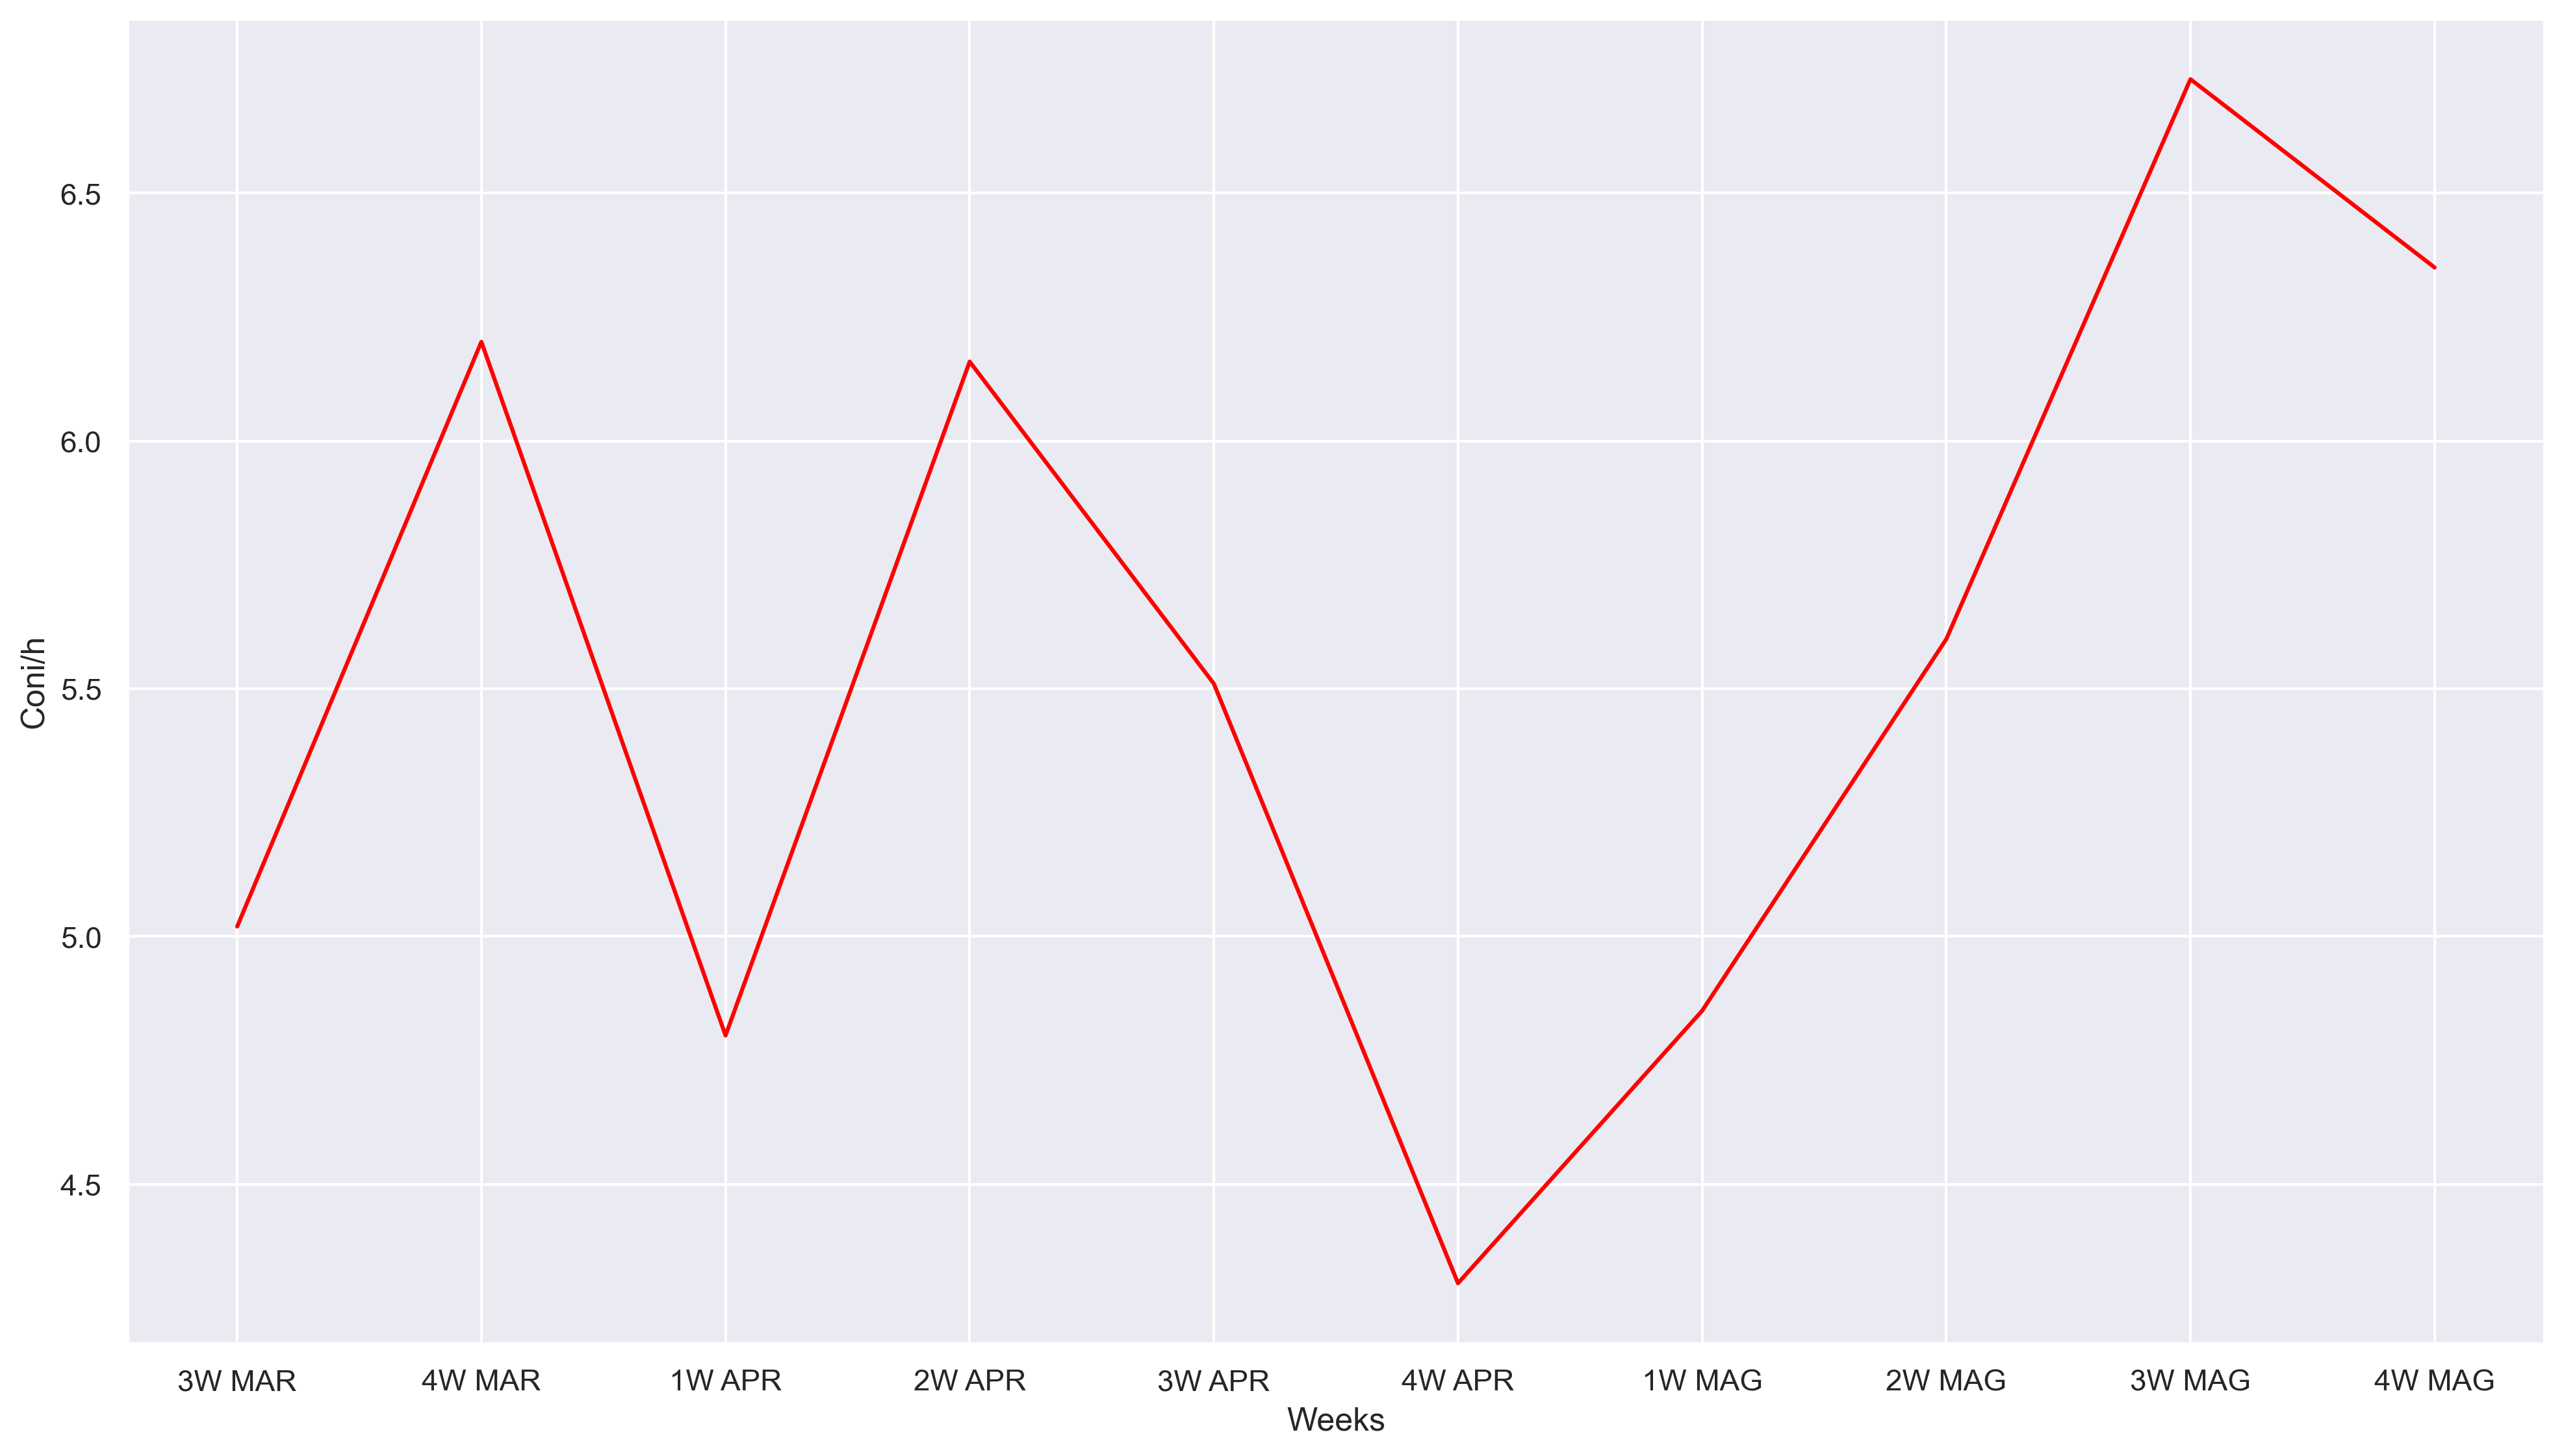

In [26]:
plt.figure(figsize=(16, 9), dpi=300)
plt.ylabel('Coni/h')
plt.xlabel('Weeks')
plt.plot(settimane, coni_ora, label='AS-IS', color='red')
'''plt.plot(h_week, p_ideal_21, label='TO-BE upperbound   8 [coni/h]', color='red')
plt.plot(h_week, p_nomir_21, label='TO-BE nel sistema    7.3 [coni/h]', color='green')
plt.plot(h_week, p_mir_21, label='TO-BE MIR not opt    6.35 [coni/h]', color='blue')
plt.fill_between(h_week, p_nomir_21, p_mir_21, color=(1/235, 120/235, 140/235), alpha=0.5)
plt.legend(prop={'size': 25})
plt.savefig('C:/Users/HP/Desktop/mezze.png')'''